<a href="https://colab.research.google.com/github/carlosarroyave/AutoEnc-GAN/blob/main/AutoEnc%26GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython import display

In [2]:
#plot original images vs reconstructed images

def plot_mnist_autoencoder(x, xpred, cmap='gray', vmin=0, vmax=1):
    # Crear una figura y ejes para mostrar las imágenes originales y reconstruidas
    fig, ax = plt.subplots(2, x.shape[0], figsize=(20, 5))

    # Iterar sobre cada imagen en x y xpred para mostrarlas en subplots correspondientes
    for i, class_ in enumerate(range(x.shape[0])):
        # Mostrar la imagen original en la fila 0 del subplot
        ax[0, i].imshow(x[i], cmap=cmap, vmin=vmin, vmax=vmax)
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])

        # Mostrar la imagen reconstruida en la fila 1 del subplot
        ax[1, i].imshow(xpred[i], cmap=cmap, vmin=vmin, vmax=vmax)
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])

    # Mostrar la figura completa con todas las subplots
    plt.show()

# Ejemplo de uso de la función
# Suponiendo que tienes imágenes en las variables x e xpred
# plot_mnist_autoencoder(x, xpred)

Identificación de por PCA de los resultados de cada capa del modelo utilizado

In [3]:
def plot_car_PCA(z, y, dim=2):
    """
    Esta función realiza PCA (Análisis de Componentes Principales) en los datos de z y
    luego visualiza las proyecciones en un gráfico de scatter para cada capa L en z.

    Args:
    - z: Objeto que contiene los datos a analizar (debe tener atributos L1, L2, ..., Ln).
    - y: Etiquetas de clase para colorear los puntos en el gráfico de dispersión.
    - dim: Número de dimensiones para la proyección PCA (por defecto es 2).

    """
    num_L = z.L_n
    fig, axes = plt.subplots(1, num_L, figsize=(10*num_L, 10))

    for i in range(num_L):
        # Obtener los datos de la capa L correspondiente
        name_Z = f"L{i+1}"
        L = getattr(z, name_Z).numpy()
        shp = L.shape

        # Realizar PCA dependiendo de la forma de los datos en la capa L
        if len(shp) == 2:
            zpca = PCA(n_components=dim).fit_transform(L.reshape((L.shape[0], L.shape[1])))
        elif len(shp) == 3:
            zpca = PCA(n_components=dim).fit_transform(L.reshape((L.shape[0], L.shape[1]*L.shape[2])))
        elif len(shp) == 4:
            zpca = PCA(n_components=dim).fit_transform(L.reshape((L.shape[0], L.shape[1]*L.shape[2]*L.shape[3])))

        # Normalizar los datos de PCA entre 0 y 1
        zpca = (zpca - zpca.min()) / (zpca.max() - zpca.min())

        # Graficar la proyección PCA en un gráfico de scatter
        axes[i].scatter(zpca[:, 0], zpca[:, 1], c=y, s=10, cmap="tab10")
        axes[i].set_title(f"L{i+1}")

    plt.subplots_adjust(wspace=0.5)
    plt.legend()
    plt.show()

# Ejemplo de uso de la función
# plot_car_PCA(z, y, dim=2)

## DataSet utlizado de keras fashion_mnist

El dataset esta calsificado en las siguientes clases :  # T-shirt/top, 	Trouser, Pullover,	Dress, 	Coat, Sandal, Shirt, 	Sneaker, Bag, Ankle boot

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


División de los datos en Train, test y valid y se normalizan los datos de 0 a 1

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [6]:
X_train[0].shape

(28, 28)

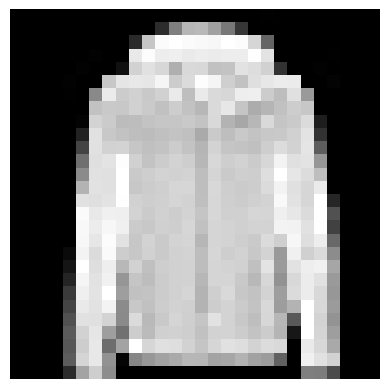

In [7]:
plt.imshow(X_train[0], cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.show()

Se mezclan los datos para garantizar que el modelo no tenga overfitting por el orden de los datos en el entrenamiento.

In [8]:
tamano = len(X_train)
indice_mezcla = np.random.permutation(tamano)
x_tr = X_train[indice_mezcla].reshape([tamano,28,28,1])
tamano = len(X_valid)
indice_mezcla = np.random.permutation(tamano)
x_vl = X_valid[indice_mezcla].reshape([tamano,28,28,1])
y_vl = y_valid[indice_mezcla]
tamano = len(X_test)
indice_mezcla = np.random.permutation(tamano)
x_ts = X_test[indice_mezcla].reshape([tamano,28,28,1])

# Modelo Autoencoder con Regularizadores

Se crea un modelo de autoencoder con una entrada de imagen (28,28) buscando reconstruir la imagen de entrada.

Se utliza la siguiente arquitectura para el encoder y decoder.

![Arquitectura](https://github.com/carlosarroyave/AutoEnc-GAN/blob/main/ArquitecturaAE.svg?raw=1)

y se utliza la API de los modelos que permite keras para poder seleccionar que tipo de regularización se va a implementar.

### Ruido gausiano:
El primer regularizador es ruido gausiano en la capa de entrada, generando un grado de aleatoriedad a los datos de entrada y evitar el sobre entrenamiento.

### Dropout:
Se genera un apagado de las neuronas de forma aleatoria en la capa implementada lo que genera que algunas neuronas no sean las que se especialicen en el entrenamiento y se pueda distribuir el aprendizaje en todas las neuronas de la capa.

###  Regularización L1 Lasso:
Introduce un termino a la función de costo (L) añadiendo al valor el absoluto de los pesos de la capa, generando que los pesos sean pequeños y no se genere una neurona con mayor importancia que las otras neuronas de la capa.

$$
L_1(X,\omega ) =  L(X,\omega ) + \lambda \sum \left |\omega_i  \right |
$$

###  Regularización L2 Ridge:

Introduce un termino a la función de costo (L) añadiendo a su valor la suma de los cuadrados de los parametros ($\omega$) y se introduce un parametro ($\lambda$) para ajustar el peso de estos cuadrados de los pesos.

$$
L_2(X,\omega ) =  L(X,\omega ) + \lambda \sum \omega_i^{2}
$$

In [9]:
class Auto_regul(Model):
    """
    Clase Auto_regul(Model):
    Esta clase implementa un modelo de red neuronal con capacidades de regularización
    para su uso en tareas de autoencoding u otros problemas de aprendizaje automático.

    Parámetros:
    - num_n_deep (list): Lista que define el número de neuronas en las capas ocultas del modelo.
    - drop_out (list): Lista que define las tasas de dropout para regularización en cada capa.
    - **kwargs: Argumentos adicionales que se pueden pasar a la clase Model.

    Atributos:
    - num_n_deep (list): Número de neuronas en las capas ocultas.
    - drop_out (list): Tasas de dropout para regularización.
    - L_n (int): Número de capas en el modelo.
    - L1-L9 (None): Capas del modelo que se inicializan como None en el constructor.

    Métodos:
    - __init__: Constructor de la clase para inicializar los atributos.
    - build: Método para construir la arquitectura del modelo basado en la forma de entrada.
    - call: Método que define la propagación hacia adelante en el modelo y la lógica de regularización.

    Uso:
    # Crear una instancia de Auto_regul
    modelo_auto_regul = Auto_regul(num_n_deep=[64, 64, 64, 1], drop_out=[0.2, 0.2])

    # Construir el modelo con la forma de entrada especificada
    modelo_auto_regul.build(input_shape=(28, 28, 1))

    # Realizar la propagación hacia adelante en el modelo con regularización específica
    output = modelo_auto_regul(inputs, regul=2)
    Selección del tipo de regularizador:
    r = 0 --- Sin gegularizador
    r = 1 --- Ruido gausiano
    r = 2 --- Dropout Capa entrada y salida Encoder
    r = 3 --- Regulairzador L1
    r = 4 --- Regulairzador L2
"""
    def __init__(self, num_n_deep= [64, 64, 64, 1], drop_out=[0.2, 0.2], **kwargs):
        super(Auto_regul, self).__init__()
        # Parámetros para la arquitectura del modelo
        self.num_n_deep = num_n_deep
        self.drop_out   = drop_out
        # Número de capas en el modelo
        self.L_n= 9
        self.L1 = None
        self.L2 = None
        self.L3 = None
        self.L4 = None
        self.L5 = None
        self.L6 = None
        self.L7 = None
        self.L8 = None
        self.L9 = None

    def build(self, input_shape, kernel_size=[3, 3, 3, 3]):

        self.kernel_size=kernel_size
        self.Pred_Layer0_Noise      = layers.GaussianNoise(0.2)
        self.Pred_Layer0_Dropout1    = layers.Dropout(self.drop_out[0])
        self.Pred_Layer1_conv1      = layers.Conv2D(filters = self.num_n_deep[0], kernel_size=self.kernel_size[0],  activation="relu")
        self.Pred_Layer2_conv2      = layers.Conv2D(filters = self.num_n_deep[1], kernel_size=self.kernel_size[1], activation="relu")
        self.Pred_Layer3_flatten    = layers.Flatten()
        self.Pred_Layer4_Dense1     = layers.Dense(units=32, activation='relu')
        self.Pred_Layer5_Dense2     = layers.Dense(units=(input_shape[1]*input_shape[2]), activation='relu')
        self.Pred_Layer5_1_Dropout2 = layers.Dropout(self.drop_out[1])
        self.Pred_Layer5_2_Regul_L1 = layers.ActivityRegularization(l1=0.1)
        self.Pred_Layer5_2_Regul_L2 = layers.ActivityRegularization(l2=0.1)
        self.Pred_Layer6_reshape1   = layers.Reshape([input_shape[1], input_shape[2], 1])
        self.Pred_Layer7_conv3      = layers.Conv2D(filters = self.num_n_deep[2], kernel_size=self.kernel_size[2], padding="SAME",  activation="relu")
        self.Pred_Layer8_conv4      = layers.Conv2D(filters = self.num_n_deep[3], kernel_size=self.kernel_size[3], padding="SAME",  activation="relu")
        self.Pred_Layer9_reshape2   = layers.Reshape([input_shape[1], input_shape[2]])
        super().build(input_shape)


    def call(self, inputs, regul=0):
        if regul == 1:
            self.inputsA = self.Pred_Layer0_Noise(inputs)
        if regul == 2:
            self.inputsA = self.Pred_Layer0_Dropout1(inputs)
        if regul == 3:
            self.inputsA = inputs
        if regul == 4:
            self.inputsA = inputs
        if regul == 0:
            self.inputsA = inputs
        self.L1  = self.Pred_Layer1_conv1(self.inputsA)
        self.L2  = self.Pred_Layer2_conv2(self.L1)
        self.L3  = self.Pred_Layer3_flatten(self.L2)
        self.L4  = self.Pred_Layer4_Dense1(self.L3)
        self.L5  = self.Pred_Layer5_Dense2(self.L4)
        if regul == 2:
            self.L5  = self.Pred_Layer5_1_Dropout2(self.L5)
        if regul == 3:
            self.L5  = self.Pred_Layer5_2_Regul_L1(self.L5)
        if regul == 4:
            self.L5  = self.Pred_Layer5_2_Regul_L2(self.L5)
        self.L6  = self.Pred_Layer6_reshape1(self.L5)
        self.L7  = self.Pred_Layer7_conv3(self.L6)
        self.L8  = self.Pred_Layer8_conv4(self.L7)
        self.L9  = self.Pred_Layer9_reshape2(self.L8)
        return self.L9

In [10]:
input_shape = (None, 28, 28, 1)

Model1 = Auto_regul()
Model1.build(input_shape)
Model1.summary()

Model: "auto_regul"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNo  multiple                  0 (unused)
 ise)                                                            
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 conv2d (Conv2D)             multiple                  640       
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  1179680   
                                                        

## Entrenamiento para Autoencoder Regularizados

### Loss MSE

Para el calculo del error o la función de costo se utliza Mean Squared Error. Se utlizo diferentes metodos de calculo de error como BinaryCrossentropy y el que presenta mejor resultado tanto como error como generalización fue MSE.


$$
MSE  = \frac{1}{n}\sum_{i=1}^{n}\left ( y_i -  \hat{y_i}\right )^{2}
$$

In [12]:
#Autoencoder Training
tf.keras.backend.clear_session()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# Define measures to track loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='val_loss')

# Training loop
epochs = 5
batch_size = 16

"""Selección del tipo de regularizador:
r = 0 --- Sin gegularizador
r = 1 --- Ruido gausiano
r = 2 --- Dropout Capa entrada y salida Encoder
r = 3 --- Regulairzador L1
r = 4 --- Regulairzador L2
"""
regularizador = 4

@tf.function
def train_step(images, reg=0):
    with tf.GradientTape() as tape:
        encod = Model1(images, reg, training=True)
        loss_enc = loss_object(images, encod)
    gradients_rec = tape.gradient(loss_enc, Model1.trainable_variables)
    optimizer.apply_gradients(zip(gradients_rec, Model1.trainable_variables))
    train_loss(loss_enc)

@tf.function
def test_step(images, reg=0):
    encod = Model1(images, reg, training=False)
    t_loss_enc = loss_object(images, encod)
    test_loss(t_loss_enc)


# Prepare the dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(x_tr).shuffle(buffer_size=1024).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_ts).shuffle(buffer_size=128).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(x_vl).shuffle(buffer_size=128).batch(batch_size)



for epoch in range(epochs):
    # Reset the metrics at the start of each epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for images in train_dataset:
        train_step(images, regularizador )

    for ts_images in test_dataset:
        test_step(ts_images, regularizador )

    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Test Loss: {test_loss.result()}')
    if (epoch+1)%0.1 == 0:
      ts_reconstructed = Model1(ts_images, regularizador, training=False)
      print(ts_reconstructed.shape)
      plot_mnist_autoencoder(ts_images,ts_reconstructed)

Model1.summary()

Epoch 1, Loss: 0.012573433108627796, Test Loss: 0.012306904420256615
Epoch 2, Loss: 0.011791043914854527, Test Loss: 0.011764181777834892
Epoch 3, Loss: 0.011243103072047234, Test Loss: 0.011419029906392097
Epoch 4, Loss: 0.010942243039608002, Test Loss: 0.011067009530961514
Epoch 5, Loss: 0.010751434601843357, Test Loss: 0.01097823679447174
Model: "auto_regul"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNo  multiple                  0 (unused)
 ise)                                                            
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 conv2d (Conv2D)             multiple                  640       
                                                                 
 conv2d_1 (Conv2D)           multiple     

### Visualización de la reconstrucción de 15 imagenes del dataset de validación

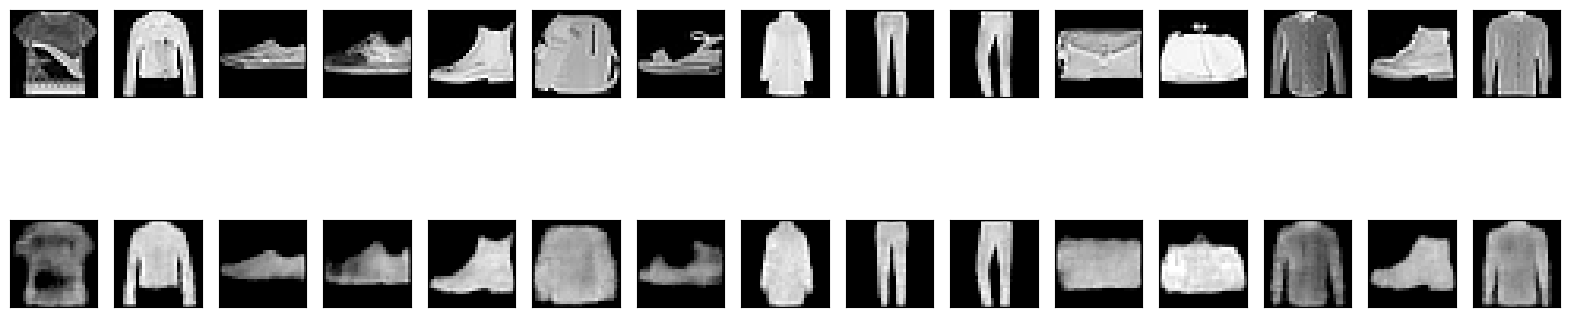

[0 4 7 7 9 8 5 4 1 1 8 8 6 9 6]


In [13]:
x_pred = Model1(x_vl[:15])

plot_mnist_autoencoder(x_vl[:15],x_pred)
print(y_vl[:15])

# Visualización PCA de las capas del modelo

Se genera una visualización por reducción de caracteristicas para poder identificar patrones y facilitar las modificaciones de los parametros entre capas. La reducción del espacio se PCA para la salida de cada capa del modelo y se colorean la imagen segun la clase.

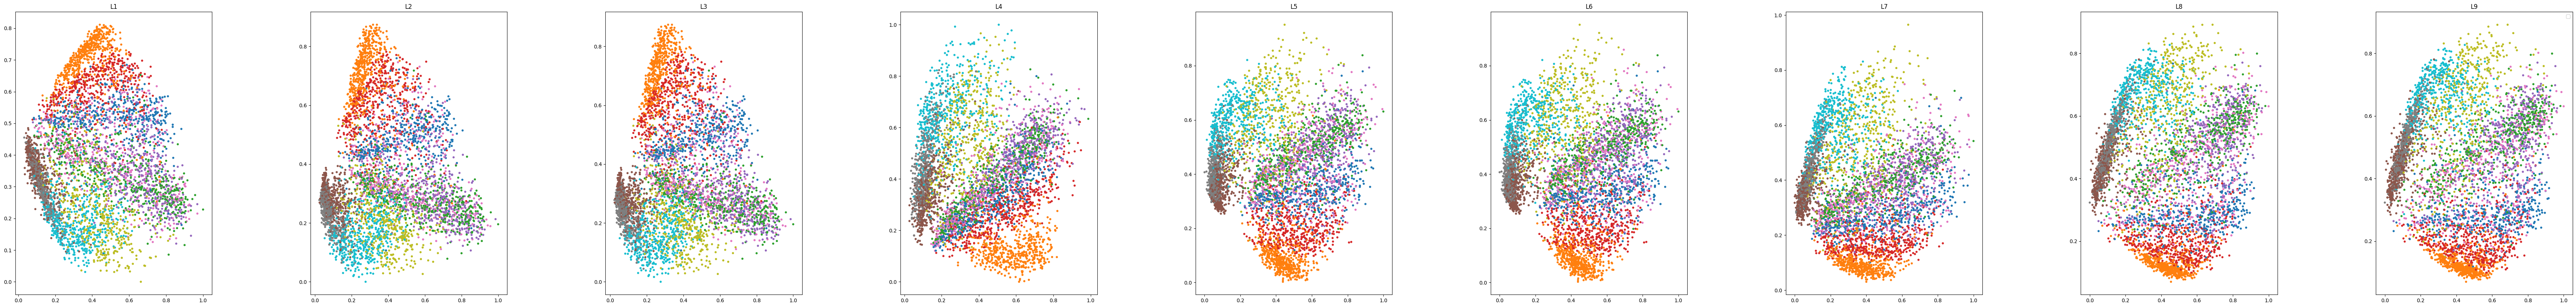

In [14]:
Model1(x_vl, regularizador)

plot_car_PCA(Model1,y_vl)

# Autoencoder Variacional VAE

Los autoencoder variacionales busca reconstruir imagenes que permita en el espacio latente tener interpolación de datos de una clase a la otra y la reconstrucción sea mas suavizada y uniforme "Regular".

Para Realizar esto definimos el espacio latente como la probabilidad de distribución de una función que describe la entrada.

$$
 Z = P(z \mid x)
$$
Por lo generar se utiliza la función de distribución de probabilidad Normal, esto le da continuidad al espacio latente.
$$
P(x)=\frac{1}{\sigma \sqrt{2\pi }}e^{-\frac{(x-\mu )^{2}}{2\sigma^{2}}}
$$

Para generar la funcion de distribución de probabilidad del encoder para el espacio latente se generan 2 capas que son las media ($\mu $) y desviación estandar log($\sigma ^{2}$). Estas son las salidas del encoder para poder modelar la función de distribución de probabilidad que siga la normal.

Para facilitar el aprendizaje el espacio latente Z se modela de la siguiente manera

$$
Z = e^{\frac{log(\sigma ^{2})}{2}}\odot \zeta +\mu
$$

Nota: Bajo modelos probabilisticos se busca resolver problemas más complejos: trabajar con multiples salidas, modelar la estructura de los datos, etc.

In [15]:
class Auto_VAE(Model):

    """
    Clase Auto_VAE(Model):
    Esta clase implementa un Variational Autoencoder (VAE), que se compone de un encoder, un sampler y un decoder.

    Parámetros:
    - num_n_deep (list): Lista que define el número de neuronas en las capas del modelo VAE.
    - **kwargs: Argumentos adicionales que se pueden pasar a la clase Model.

    Atributos:
    - num_n_deep (list): Número de neuronas en las capas del modelo VAE.
    - mean (None): Variable para almacenar la media de la distribución latente.
    - log_var (None): Variable para almacenar el logaritmo de la varianza de la distribución latente.
    - L_n (int): Número de capas en el modelo VAE.
    - L1-L12 (None): Capas del modelo VAE que se inicializan como None en el constructor.

    Métodos:
    - __init__: Constructor de la clase para inicializar los atributos.
    - build: Método para construir la arquitectura del modelo VAE basado en la forma de entrada.
    - call: Método que define la propagación hacia adelante en el modelo VAE y el muestreo en el espacio latente.

    Uso:
    # Crear una instancia de Auto_VAE
    modelo_vae = Auto_VAE(num_n_deep=[64, 32, 64, 2, 64, 576])

    # Construir el modelo VAE con la forma de entrada especificada
    modelo_vae.build(input_shape=(28, 28, 1))

    # Realizar la propagación hacia adelante en el modelo VAE con una entrada y generar una salida
    output_decodificado = modelo_vae(inputs, gen=False)
    """
    def __init__(self, num_n_deep= [64, 32, 64, 2, 64, 576], **kwargs):
        super(Auto_VAE, self).__init__()
        self.num_n_deep = num_n_deep
        self.mean = None
        self.log_var = None
        self.L_n= 12
        self.L1 = None
        self.L2 = None
        self.L3 = None
        self.L4 = None
        self.L5 = None
        self.L6 = None
        self.L7 = None
        self.L8 = None
        self.L9 = None
        self.L10 = None
        self.L11 = None
        self.L12 = None

    def build(self, input_shape, kernel_size=[3, 3, 3, 3]):
        self.kernel_size = kernel_size
        self.VAE_Layer0_Noise       = layers.GaussianNoise(0.2)
        self.VAE_Layer1_conv1        = layers.Conv2D(filters = self.num_n_deep[0], kernel_size=self.kernel_size[0], strides=(2, 2), activation="relu")
        self.VAE_Layer2_conv2        = layers.Conv2D(filters = self.num_n_deep[1], kernel_size=self.kernel_size[1], strides=(2, 2),  activation="relu")
        self.VAE_Layer2_Flatten1     = layers.Flatten()
        self.VAE_Layer3_Dense1       = layers.Dense(units=self.num_n_deep[2], activation='relu')
        self.VAE_Layer4_Mean         = layers.Dense(units=self.num_n_deep[3])
        self.VAE_Layer5_Log_var      = layers.Dense(units=self.num_n_deep[3])
        self.VAE_Layer7_Dense2       = layers.Dense(units=self.num_n_deep[4], activation='relu')
        self.VAE_Layer8_Dense3       = layers.Dense(units=self.num_n_deep[5], activation='relu')
        self.VAE_Layer9_reshape1     = layers.Reshape([24, 24, 1])
        self.VAE_Layer10_conv3       = layers.Conv2DTranspose(filters = self.num_n_deep[1], kernel_size=self.kernel_size[2],  activation="relu")
        self.VAE_Layer11_conv4       = layers.Conv2DTranspose(filters = 1, kernel_size=self.kernel_size[3],  activation="sigmoid")
        self.VAE_Layer12_reshape2    = layers.Reshape([input_shape[1], input_shape[2],1])
        super().build(input_shape)



    def call(self, inputs, gen=False):
        def Ngaussian(Enc):
            self.mean, self.log_var = Enc
            return keras.backend.random_normal(tf.shape(self.log_var)) * keras.backend.exp(self.log_var / 2) + self.mean

        if gen == False:
            #self.L0  = self.VAE_Layer0_Noise(inputs)
            self.L1  = self.VAE_Layer1_conv1(inputs)
            self.L2  = self.VAE_Layer2_conv2(self.L1)
            self.L2  = self.VAE_Layer2_Flatten1(self.L2)
            self.L3  = self.VAE_Layer3_Dense1(self.L2)
            self.L4  = self.VAE_Layer4_Mean(self.L3)
            self.L5  = self.VAE_Layer5_Log_var(self.L3)
            self.L6   = Ngaussian((self.L4, self.L5))
        if gen == True:
            self.L6   = inputs
        self.L7  = self.VAE_Layer7_Dense2(self.L6)
        self.L8  = self.VAE_Layer8_Dense3(self.L7)
        self.L9  = self.VAE_Layer9_reshape1(self.L8)
        self.L10  = self.VAE_Layer10_conv3(self.L9)
        self.L11  = self.VAE_Layer11_conv4(self.L10)
        self.L12  = self.VAE_Layer12_reshape2(self.L11)
        return self.L12

In [16]:
input_shape = (None, 28, 28, 1)

Model2 = Auto_VAE()
Model2.build(input_shape)
Model2.summary()

Model: "auto_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNo  multiple                  0 (unused)
 ise)                                                            
                                                                 
 conv2d (Conv2D)             multiple                  640       
                                                                 
 conv2d_1 (Conv2D)           multiple                  18464     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  73792     
                                                                 
 dense_1 (Dense)             multiple                  130       
                                                          

##  Kullback-Leibler divergence KL
El loss para VAE Se utiliza dos loss uno que es la diferencia de la reconstrucción por BinaryCrossEntropy y el Kullback–Leibler divergence el cual es un metodo matematico para calcular la distancia estadistica entre dos funciones de distribución de probabilidad. para nuestro caso como no tenemos la función de ditribución real para poder determinar la diferencie entre ellas asumimos que la funcion de ditribución debe ser una normal con media 0 y variación estandar de 1.
$$
BinaryCrossEntropy = \frac{1}{N}\sum_{i=1}^{N}\left [ y_i*log(y_{pred})+(1-y_i)*log(1-y_{pred}) \right ]\\ \\ \\
$$

$$
KL[N(\mu_{x},\sigma_{x}),N(0,1)] = -0.5 * \sum_{i=1}^{n}(1+log(Z_{\sigma i}^{2})-Z_{\mu i}^{2}-e^{log(Z_{\sigma i}^{2})})\\ \\ \\
$$

$$
loss=BinaryCrossEntropy+KL[N(\mu_{x},\sigma_{x}),N(0,1)]\\
$$

In [19]:
optimizer = tf.keras.optimizers.Adam(1e-4)

epochs=20
batch_size=64
# Define measures to track loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='val_loss')

# Prepare the dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(x_tr).shuffle(buffer_size=1024).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_ts).shuffle(buffer_size=128).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(x_vl).shuffle(buffer_size=128).batch(batch_size)


def compute_loss(model, x):
  X=model(x)
  mean= model.L4
  logvar = model.L5
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(x, X),axis=(1, 2),))
  kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  total_loss = reconstruction_loss + kl_loss
  return total_loss


@tf.function
def train_step_VAE(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)

@tf.function
def test_step_VAE(model, x):
  loss_test = compute_loss(model, x)
  test_loss(loss_test)


for epoch in range(epochs):
  train_loss.reset_states()
  test_loss.reset_states()
  for images in train_dataset:
      train_step_VAE(Model2, images,  optimizer)
  for ts_images in test_dataset:
      test_step_VAE(Model2, ts_images)
  print(f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Test Loss: {test_loss.result()}')
  #if (epoch+1)%0.1 == 0:
    #ts_reconstructed = Model1(ts_images, training=False)
    #print(ts_reconstructed.shape)
    #plot_mnist_autoencoder(ts_images,ts_reconstructed)

Epoch 1, Loss: 292.57244873046875, Test Loss: 291.85992431640625
Epoch 2, Loss: 289.16607666015625, Test Loss: 288.98388671875
Epoch 3, Loss: 286.5660095214844, Test Loss: 286.65411376953125
Epoch 4, Loss: 284.4810791015625, Test Loss: 284.4617004394531
Epoch 5, Loss: 282.6412353515625, Test Loss: 283.1075439453125
Epoch 6, Loss: 281.08319091796875, Test Loss: 281.3643493652344
Epoch 7, Loss: 279.7184143066406, Test Loss: 279.78289794921875
Epoch 8, Loss: 278.446533203125, Test Loss: 279.2135314941406
Epoch 9, Loss: 277.444580078125, Test Loss: 278.0694580078125
Epoch 10, Loss: 276.5755920410156, Test Loss: 277.15093994140625
Epoch 11, Loss: 275.7007751464844, Test Loss: 276.72760009765625
Epoch 12, Loss: 274.9711608886719, Test Loss: 275.84942626953125
Epoch 13, Loss: 274.35601806640625, Test Loss: 275.2607421875
Epoch 14, Loss: 273.83740234375, Test Loss: 274.9463195800781
Epoch 15, Loss: 273.27899169921875, Test Loss: 274.4034118652344
Epoch 16, Loss: 272.7847595214844, Test Loss: 2

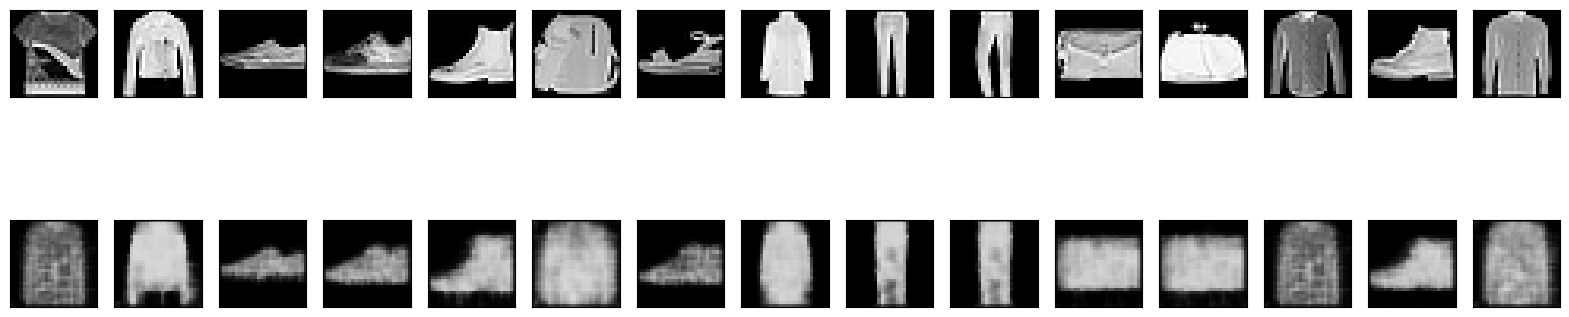

[0 4 7 7 9 8 5 4 1 1 8 8 6 9 6]


In [20]:
x_pred = Model2(x_vl[:15])

plot_mnist_autoencoder(x_vl[:15],x_pred)
print(y_vl[:15])

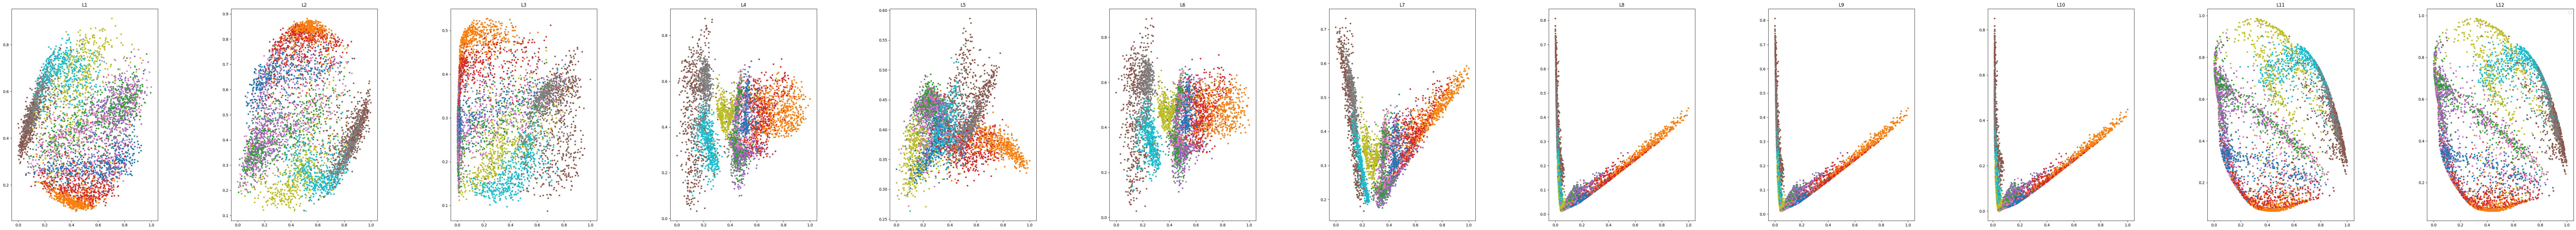

In [21]:
Model2(x_vl)

plot_car_PCA(Model2,y_vl)

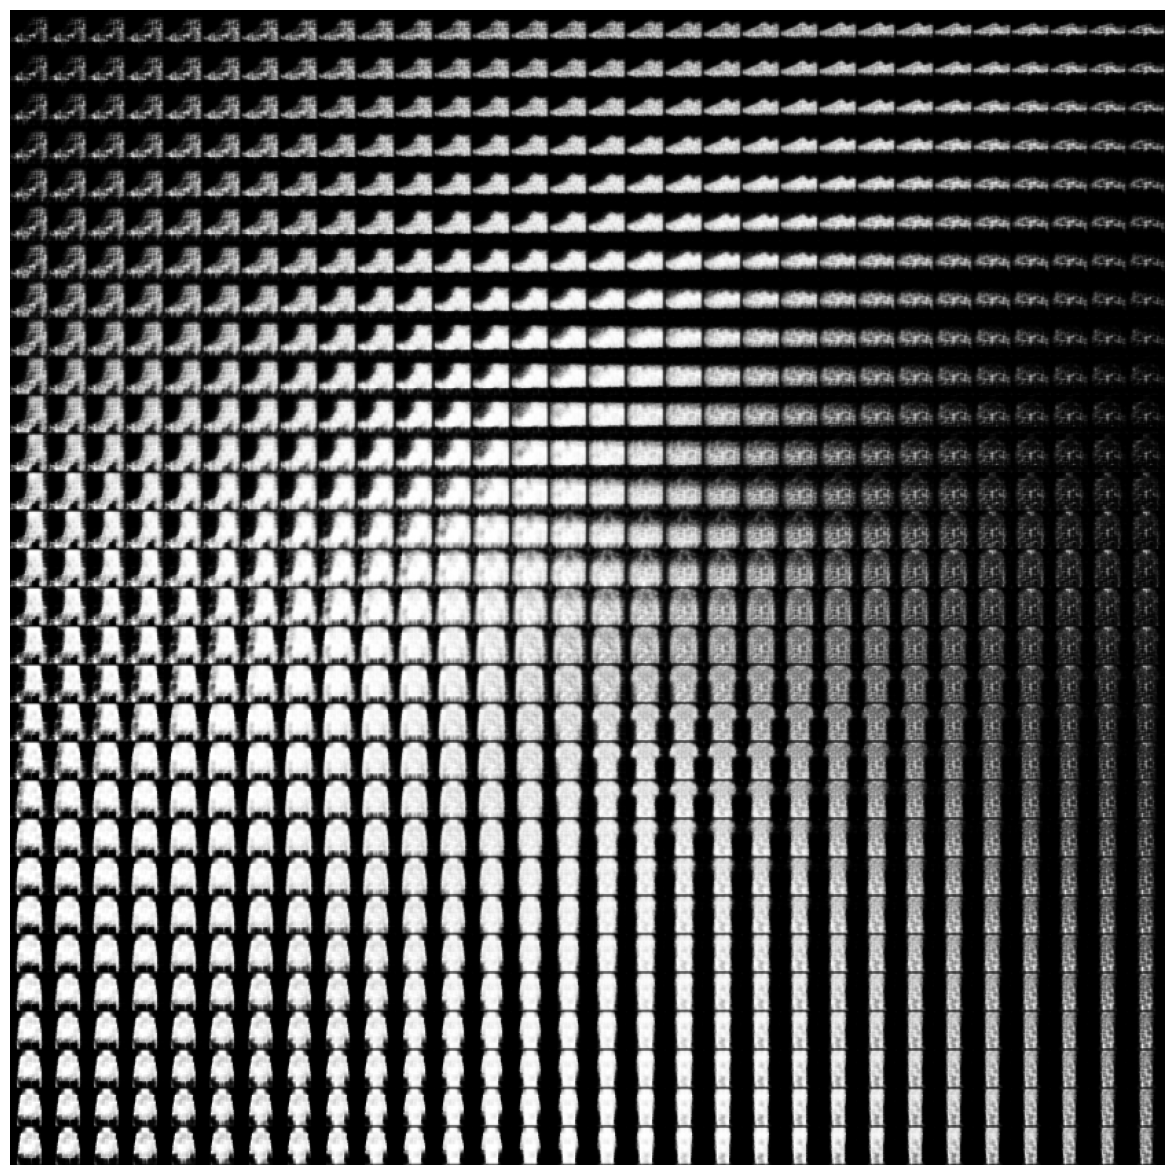

In [22]:
numImgs = 30
newrows,newcols=28,28
lo, hi  = -2,2

z1 = np.linspace(lo, hi, numImgs)
z2 = np.linspace(lo, hi, numImgs)

plt.figure(figsize=(15,15*newcols/newrows))
canvas=np.zeros((newrows*numImgs,newcols*numImgs))
for i in range(numImgs):
    for j in range(numImgs):
        z=np.array([z1[i], z2[j] ])
        z=np.expand_dims(z, axis=0)
        Im=Model2(z, gen=True).numpy()
        canvas[newrows*i:newrows*(i+1), newcols*j:newcols*(j+1)] = Im.reshape((newrows,newcols))

plt.imshow(canvas, 'gray')
plt.axis('off')
plt.show()

## GAN transformación inversa.
Las GAN utilizan dos redes neuronales, una que se encarga de realizar la genereación de (imagen, texto, etc) y otra red que es entrenada para determinar si la imagen generada es real o fake, de esta manera se entrena el modelo generativo para identificar la CDF o función de densidad de probabilidad que asemeje a la generación de un dato al espacio de los datos de entrenamiento de forma indirecta, ya que no conocemos el CDF real de los datos. El entrenamiento se hace para que el generador engañe al discriminador y el discriminador detecte la imagen fake. Por tal motivo es el nombre adversarias ya que una se contrapone a la otra red y asi la competencia hace que se mejore la CDF de la red.


La GAN es un modelo generativo se basa en la transformación inversa de una función de densidad de probabilidad, el objetivo es encontrar la función de densidad de probabilidad que se asemeje a la de nuestro conjunto de entrenamiento.

$$
CDF_X(x)=P(X\leq x )\\
$$

$$
CDF_U(u)=P(U\leq u )= u \\
$$

$$
    Y = CDF_X^{-1}(U)
$$

In [23]:
class Gen_GAN(Model):
    """
    Clase Gen_GAN(Model):
    Esta clase implementa un generador para una Red Generativa Adversarial (GAN), que toma una entrada de ruido
    y genera una imagen.

    Parámetros:
    - num_n_deep (list): Lista que define el número de neuronas en las capas ocultas del generador.
    - **kwargs: Argumentos adicionales que se pueden pasar a la clase Model.

    Atributos:
    - num_n_deep (list): Número de neuronas en las capas ocultas del generador.
    - mean (None): Variable para almacenar la media de la distribución latente (no se utiliza en este código).
    - log_var (None): Variable para almacenar el logaritmo de la varianza de la distribución latente (no se utiliza aquí).
    - L_n (int): Número de capas en el generador.

    Métodos:
    - __init__: Constructor de la clase para inicializar los atributos.
    - build: Método para construir la arquitectura del generador basado en la forma de entrada.
    - call: Método que define la propagación hacia adelante en el generador.

    """
    def __init__(self, num_n_deep= [16*16*128, 64, 16], **kwargs):
        super(Gen_GAN, self).__init__()
        self.num_n_deep = num_n_deep
        self.mean = None
        self.log_var = None
        self.L_n= 9
        self.L1 = None
        self.L2 = None
        self.L3 = None
        self.L4 = None
        self.L5 = None
        self.L6 = None
        self.L7 = None
        self.L8 = None
        self.L9 = None

    def build(self, input_shape, output_shape_p=[28, 28, 1]):
        self.output_shape_p = output_shape_p
        self.GAN_Layer1_Dense1    = layers.Dense(self.num_n_deep[0], use_bias=False, input_shape=(input_shape))
        self.GAN_Layer2_Norm1     = layers.BatchNormalization()
        self.GAN_Layer3_reshape1  = layers.Reshape([16,16,128])
        self.GAN_Layer4_conv1     = layers.Conv2DTranspose(self.num_n_deep[1], kernel_size=5, activation="relu")
        self.GAN_Layer5_Norm2     = layers.BatchNormalization()
        self.GAN_Layer6_conv2     = layers.Conv2DTranspose(self.num_n_deep[2], kernel_size=5, activation="relu")
        self.GAN_Layer7_Norm3     = layers.BatchNormalization()
        self.GAN_Layer8_conv3     = layers.Conv2DTranspose(1, kernel_size=5, activation="tanh")
        self.GAN_Layer9_reshape2  = layers.Reshape(self.output_shape_p)

        super().build(input_shape)



    def call(self, inputs):

        self.L1  = self.GAN_Layer1_Dense1(inputs)
        self.L2  = self.GAN_Layer2_Norm1(self.L1)
        self.L3  = self.GAN_Layer3_reshape1(self.L2)
        self.L4  = self.GAN_Layer4_conv1(self.L3)
        self.L5  = self.GAN_Layer5_Norm2(self.L4)
        self.L6  = self.GAN_Layer6_conv2(self.L5)
        self.L7  = self.GAN_Layer7_Norm3(self.L6)
        self.L8  = self.GAN_Layer8_conv3(self.L7)
        self.L9  = self.GAN_Layer9_reshape2(self.L8)
        return self.L9

In [24]:
class Dis_GAN(Model):
    """
    Clase Dis_GAN(Model):
    Esta clase implementa un discriminador para una Red Generativa Adversarial (GAN), que evalúa la autenticidad
    de una imagen generada por el generador.

    Parámetros:
    - num_n_deep (list): Lista que define el número de neuronas en las capas convolucionales del discriminador.
    - **kwargs: Argumentos adicionales que se pueden pasar a la clase Model.

    Atributos:
    - num_n_deep (list): Número de neuronas en las capas convolucionales del discriminador.
    - mean (None): Variable para almacenar la media de la distribución latente (no se utiliza en este código).
    - log_var (None): Variable para almacenar el logaritmo de la varianza de la distribución latente (no se utiliza aquí).
    - L_n (int): Número de capas en el discriminador.
    - L1-L6 (None): Capas del discriminador que se inicializan como None en el constructor.

    Métodos:
    - __init__: Constructor de la clase para inicializar los atributos.
    - build: Método para construir la arquitectura del discriminador basado en la forma de entrada.
    - call: Método que define la propagación hacia adelante en el discriminador.

    Uso:
    # Crear una instancia de Dis_GAN
    discriminador_gan = Dis_GAN(num_n_deep=[64, 128, 1])

    # Construir el discriminador con la forma de entrada especificada
    discriminador_gan.build(input_shape=(28, 28, 1))

    # Realizar la propagación hacia adelante en el discriminador con una imagen de entrada
    output_autenticidad = discriminador_gan(input_imagen_generada)
    """

    def __init__(self, num_n_deep= [64, 128, 1], **kwargs):
        super(Dis_GAN, self).__init__()
        self.num_n_deep = num_n_deep
        self.mean = None
        self.log_var = None
        self.L_n= 6
        self.L1 = None
        self.L2 = None
        self.L3 = None
        self.L4 = None
        self.L5 = None
        self.L6 = None

    def build(self, input_shape):
        self.GAN_Layer1_conv1       = layers.Conv2D(self.num_n_deep[0], kernel_size=5, strides=(2, 2), padding='same', activation="relu", input_shape=(input_shape))
        self.GAN_Layer2_Dropou1      = layers.Dropout(0.2)
        self.GAN_Layer3_conv2       = layers.Conv2D(self.num_n_deep[1], kernel_size=5, strides=(2, 2), padding='same', activation="relu")
        self.GAN_Layer4_Dropou2      = layers.Dropout(0.2)
        self.GAN_Layer5_flatten1    = layers.Flatten()
        self.GAN_Layer6_Dense1      = layers.Dense(units=self.num_n_deep[2], activation='sigmoid')

        super().build(input_shape)



    def call(self, inputs):

        self.L1  = self.GAN_Layer1_conv1(inputs)
        self.L2  = self.GAN_Layer2_Dropou1(self.L1)
        self.L3  = self.GAN_Layer3_conv2(self.L2)
        self.L4  = self.GAN_Layer4_Dropou2(self.L3)
        self.L5  = self.GAN_Layer5_flatten1 (self.L4)
        self.L6  = self.GAN_Layer6_Dense1(self.L5)
        return self.L6

In [25]:
input_shape = (None, 100)

Model3 = Gen_GAN()
Model3.build(input_shape)
Model3.summary()

input_shape = (None, 28, 28, 1)

Model4 = Dis_GAN()
Model4.build(input_shape)
Model4.summary()

Model: "gen_gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             multiple                  3276800   
                                                                 
 batch_normalization (Batch  multiple                  131072    
 Normalization)                                                  
                                                                 
 reshape_2 (Reshape)         multiple                  0         
                                                                 
 conv2d_transpose_2 (Conv2D  multiple                  204864    
 Transpose)                                                      
                                                                 
 batch_normalization_1 (Bat  multiple                  256       
 chNormalization)                                                
                                                           

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

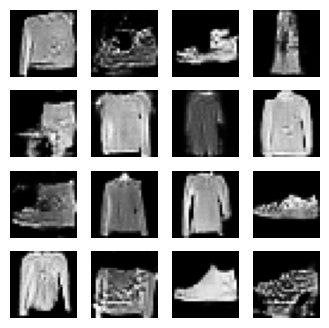

In [28]:
EPOCHS = 5
BATCH_SIZE = 16
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = Model3(noise, training=True)

      real_output = Model4(images, training=True)
      fake_output = Model4(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, Model3.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, Model4.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, Model3.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, Model4.trainable_variables))



def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(Model3,
                             epoch + 1,
                             seed)


    print ('epoch_')

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(Model3,epochs,seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

train_dataset = tf.data.Dataset.from_tensor_slices(x_tr*2-1).shuffle(buffer_size=1024).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)